In [207]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random

# Creating Flare Injection Data For Synthetic Evaluation Set

In [240]:
# Function to select a flare profile
def select_flare_profile(df, start_time, end_time, date_col='Date'):
    flare_profile = df[(df[date_col] >= start_time) & (df[date_col] <= end_time)]
    return flare_profile.reset_index(drop=True)

# Function to inject a flare profile into a region of the time series data
def inject_flare(df, flare_profile, region_start, region_end, date_col='Date'):
    region = df[(df[date_col] >= region_start) & (df[date_col] <= region_end)].reset_index(drop=True)
    
    # Interpolate flare_profile to the time grid of the region
    # interp_function = interp1d(flare_profile["Flux"], flare_profile["Flux"], kind='quadratic', fill_value='extrapolate')
    # region_time = region["Flux"]
    # interpolated_flux = interp_function(region_time)
    
    # subtract the end points of the region at end points of flare profile
    center_idx = len(region) // 2
    flare_center_idx = len(flare_profile) // 2
    diff_profile = flare_profile["Flux"].iloc[0] - region["Flux"].iloc[center_idx - flare_center_idx]

    # Inject the flare profile into the center of the region
    for i in range(len(flare_profile)):
        inject_idx = center_idx - flare_center_idx + i
        if 0 <= inject_idx < len(region):
            region.at[inject_idx, 'Flux'] += flare_profile.at[i, 'Flux'] - diff_profile #- np.mean(region['Flux']) #interpolated_flux[inject_idx] # cheating here a little bit, need to fix this with interpolating
            # need to take difference between end points of region flux and profile flux
            region.at[inject_idx,'Flare'] = flare_profile.at[i, 'Flare']
    
    return region

## Testing Injection Method

In [209]:
# Example usage
df = pd.read_csv("/Users/joshuaingram/Main/Projects/SolarFlareNN/data/FlaresGoes161718Wavelet_2.csv")
df.head()

/var/folders/k3/6x6tz2rj1qb4727bvm_ytpqc0000gn/T/ipykernel_40032/2899213252.py:2: DtypeWarning: Columns (5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/joshuaingram/Main/Projects/SolarFlareNN/data/FlaresGoes161718Wavelet_2.csv")


,Date,secs_since_2000,Flux16,Flux17,Flux18,Status16,Status17,Status18,Flare16,Flare17,Flare18,Flux,Flare,Wavelet16,Wavelet17,Wavelet18,Wavelet
0,2017-02-07T00:00:00Z,539697600,7.072423e-08,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,7.072423e-08,0,NaN,NaN,NaN,0
1,2017-02-07T00:01:00Z,539697660,6.869706e-08,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,6.869706e-08,0,NaN,NaN,NaN,0
2,2017-02-07T00:02:00Z,539697720,6.933664e-08,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,6.933664e-08,0,NaN,NaN,NaN,0
3,2017-02-07T00:03:00Z,539697780,6.796333e-08,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,6.796333e-08,0,NaN,NaN,NaN,0
4,2017-02-07T00:04:00Z,539697840,6.928261e-08,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,6.928261e-08,0,NaN,NaN,NaN,0


In [210]:
df = df[['Date', 'secs_since_2000', 'Flux', 'Flare', 'Wavelet']] # this means regions with no flares determined by wavelet
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.tz_localize(None)
print(df.head())

                 Date  secs_since_2000          Flux  Flare  Wavelet
0 2017-02-07 00:00:00        539697600  7.072423e-08      0        0
1 2017-02-07 00:01:00        539697660  6.869706e-08      0        0
2 2017-02-07 00:02:00        539697720  6.933664e-08      0        0
3 2017-02-07 00:03:00        539697780  6.796333e-08      0        0
4 2017-02-07 00:04:00        539697840  6.928261e-08      0        0


In [211]:
flare_profile_lower = datetime(2019, 1, 2, 6, 15, 0)
flare_profile_upper = datetime(2019, 1, 2, 7, 15, 0)
print(flare_profile_lower, flare_profile_upper)


inject_region_lower = datetime(2019, 1, 1, 12, 0, 0)
inject_region_upper = datetime(2019, 1, 1, 18, 0, 0)
print(inject_region_lower, inject_region_upper)

2019-01-02 06:15:00 2019-01-02 07:15:00
2019-01-01 12:00:00 2019-01-01 18:00:00


In [212]:
flare_profile = select_flare_profile(df, flare_profile_lower, flare_profile_upper)
region = select_flare_profile(df, inject_region_lower, inject_region_upper)
df_injected = inject_flare(df, flare_profile, inject_region_lower, inject_region_upper)

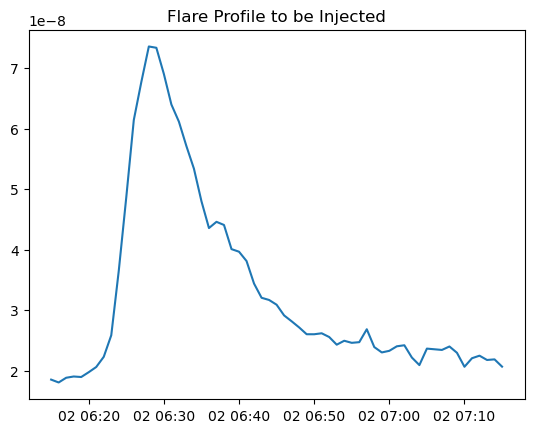

In [213]:
# Flare Profile to be injected
plt.plot(flare_profile['Date'], flare_profile['Flux'], label='Profile')
plt.title('Flare Profile to be Injected')
plt.show()

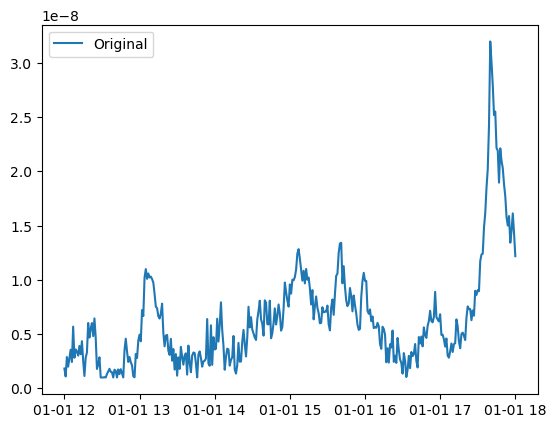

In [214]:
# time region where flare profile will be injected
plt.plot(region['Date'], region['Flux'], label='Original')
# plt.plot(df_injected['Date'], df_injected['Flux'], label='Injected')
plt.legend()
plt.show()

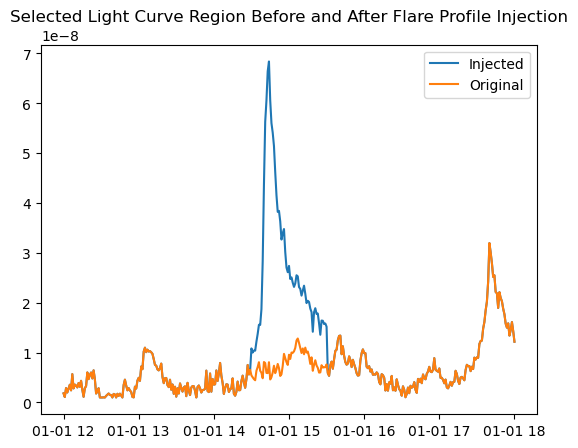

In [215]:
plt.plot(df_injected['Date'], df_injected['Flux'], label='Injected')
plt.plot(region['Date'], region['Flux'], label='Original')
plt.title('Selected Light Curve Region Before and After Flare Profile Injection')
# plt.plot(flare_profile['Date'], flare_profile['Flux'], label='Profile')
plt.legend()
plt.show()

# Create Evaluation Set

In [216]:
# Load flare profile summaries
events = pd.read_csv("/Users/joshuaingram/Main/Projects/SolarFlareNN/data/GOES_clean.csv")
events['Gstart'] = pd.to_datetime(events['Gstart'])
events['Gstart'] = events['Gstart'].dt.tz_localize(None)
events['Gpeak'] = pd.to_datetime(events['Gpeak'])
events['Gpeak'] = events['Gpeak'].dt.tz_localize(None)
events['Gstop'] = pd.to_datetime(events['Gstop'])
events['Gstop'] = events['Gstop'].dt.tz_localize(None)

# Separate flare events by class
events_Aclass = events[events['class'] == 'A']
events_Aclass = events_Aclass[events_Aclass['Gpeak'] > datetime(2017, 3, 1, 0, 0, 0)]

events_Bclass = events[events['class'] == 'B']
events_Bclass = events_Bclass[events_Bclass['Gpeak'] > datetime(2017, 3, 1, 0, 0, 0)]

events_Cclass = events[events['class'] == 'C']
events_Cclass = events_Cclass[events_Cclass['Gpeak'] > datetime(2017, 3, 1, 0, 0, 0)]

events_Mclass = events[events['class'] == 'M']
events_Mclass = events_Mclass[events_Mclass['Gpeak'] > datetime(2017, 3, 1, 0, 0, 0)]

events_Xclass = events[events['class'] == 'X']
events_Xclass = events_Xclass[events_Xclass['Gpeak'] > datetime(2017, 3, 1, 0, 0, 0)]

In [217]:
# select 5 random flare profiles from each class
# events_Aclass = events_Aclass.sample(n=5)
# events_Bclass = events_Bclass.sample(n=5)
events_Cclass = events_Cclass.sample(n=5)
events_Mclass = events_Mclass.sample(n=5)
events_Xclass = events_Xclass.sample(n=1)

In [218]:
# select profiles for each event class <- need to use Gpeaks for label columns 0, 1
events_Cclass_profiles = []
for i in range(len(events_Cclass)):
    events_Cclass_profiles.append(select_flare_profile(df, events_Cclass.iloc[i]['Gstart'] - timedelta(minutes = 5), events_Cclass.iloc[i]['Gstop'] + timedelta(minutes = 10)))

events_Mclass_profiles = []
for i in range(len(events_Mclass)):
    events_Mclass_profiles.append(select_flare_profile(df, events_Mclass.iloc[i]['Gstart'] - timedelta(minutes = 10), events_Mclass.iloc[i]['Gstop'] + timedelta(minutes = 20)))

events_Xclass_profiles = []
for i in range(1):
    events_Xclass_profiles.append(select_flare_profile(df, events_Xclass.iloc[i]['Gstart'] - timedelta(minutes = 10), events_Xclass.iloc[i]['Gstop'] + timedelta(minutes = 25)))

event_profiles = events_Cclass_profiles + events_Mclass_profiles + events_Xclass_profiles

#print(events_Cclass_profiles[1])
#plt.plot(events_Cclass_profiles[1]['Date'], events_Cclass_profiles[1]['Flux'])
#plt.show()
#plt.plot(events_Mclass_profiles[1]['Date'], events_Mclass_profiles[1]['Flux'])
#plt.show()
#plt.plot(events_Xclass_profiles[0]['Date'], events_Xclass_profiles[0]['Flux'])
#plt.show()


In [219]:
# select 1000 random regions from the time series data of length 60 minutes
flare_indices = df.index[df['Flare'] == 1].tolist()
wavelet_indices = df.index[df['Wavelet'] == 1].tolist()

exclude_indices = set(flare_indices)
for k in range(1):
    exclude_indices.update([idx + k for idx in wavelet_indices])
    exclude_indices.update([idx - k for idx in wavelet_indices])

nonflare_indices = set(range(45 + 1, len(df) - (45 + 1))) - exclude_indices # wavelet indices might be too constrictive
nonflare_indices = random.sample(nonflare_indices, 1000)

regions = []
for i in nonflare_indices:
    # select min and max date of region
    region_start = df.iloc[i - 60]['Date']
    region_end = df.iloc[i + 60]['Date']
    regions.append([region_start, region_end])

/var/folders/k3/6x6tz2rj1qb4727bvm_ytpqc0000gn/T/ipykernel_40032/1464485372.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  nonflare_indices = random.sample(nonflare_indices, 1000)


In [220]:
print(regions[1])
print(event_profiles[0]['Flare'].max())
print(len(regions))

[Timestamp('2017-10-07 20:12:00'), Timestamp('2017-10-07 22:12:00')]
1
1000


In [221]:
# inject flare profiles into the 1000 regions <- this is terrible runtime... need to fix
injected_regions = []
for i in range(len(regions)):
    for profile in event_profiles:
        injected_regions.append(inject_flare(df, profile, regions[i][0], regions[i][1]))
injected_regions = [injected_regions[i] for i in range(len(injected_regions)) if injected_regions[i]['Flare'].max() == 1]

In [249]:
injected_regions[6303]['Flux'].isna()

0      False
1      False
2      False
3      False
4      False
       ...  
116    False
117    False
118    False
119    False
120    False
Name: Flux, Length: 121, dtype: bool

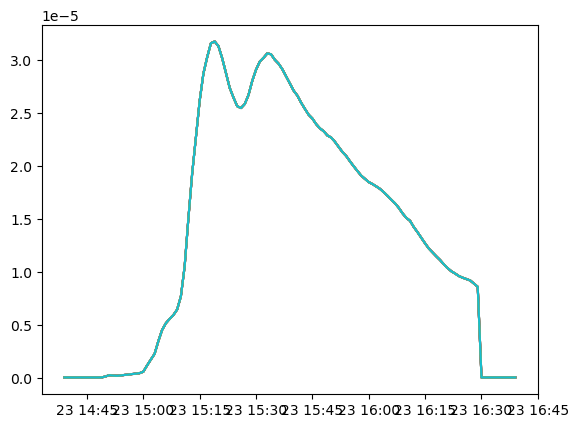

In [239]:
for i in range(10):
    plt.plot(injected_regions[6303]['Date'], injected_regions[6303]['Flux']) # window sizes need to be much larger for CNN, like +/- 30 minutes
plt.show()

In [125]:
# sum([1 for i in range(len(injected_regions)) if injected_regions[i]['Flare'].max() == 1]) # not all injections have a 1 label?

In [266]:
# create windowed data for CNN
# Step 1: Read the CSV file
designaled2017_2022 = pd.read_csv("/Users/joshuaingram/Main/Projects/SolarFlareNN/Goes161718_wavelet_designaled_flux_Aclass.csv")

# get indices of where flare occurs in each region
flare_indices = []
for i in range(len(injected_regions)):
    #print(injected_regions[i].index[injected_regions[i]['Flare'] == 1])
    flare_indices.append(injected_regions[i].index[injected_regions[i]['Flare'] == 1].tolist()[0])
    #print(flare_indices)

# Step 3: Initialize parameters and matrices
hist1 = 15  # mins before
hist2 = 15  # mins after
nonflareMultiple = 20  # how many non-flares to generate for every flare
cols = hist1 + hist2 + 1 + 1 + 1

numFlares = len(injected_regions)

FlareProfiles = np.empty((numFlares, cols))
FlareProfiles[:] = np.nan

j = 0
for i in range(len(injected_regions)):
    if flare_indices[i] > hist1 and flare_indices[i] < len(injected_regions[i]) - hist2:
        fluxes = injected_regions[i]['Flux'].iloc[(flare_indices[i] - hist1):(flare_indices[i] + hist2 + 1)] / injected_regions[flare_indices[i]]['Flux'].iloc[flare_indices[i]]
        FlareProfiles[j, :-2] = fluxes.values
        FlareProfiles[j, -2] = 1
        FlareProfiles[j, -1] = injected_regions[i]['secs_since_2000'].iloc[flare_indices[i]]
        j += 1


# Step 5: create designaled/noise profiles
numNoise = j
noise_indices = set(range(hist1 + 1, len(designaled2017_2022) - (hist2 + 1)))
noise_indices = random.sample(noise_indices, int(numNoise))

NoiseProfiles = np.empty((numNoise, cols))
NoiseProfiles[:] = np.nan

j = 0
for i in noise_indices:
    fluxes = designaled2017_2022['designaled_flux'].iloc[(i - hist1):(i + hist2 + 1)] / designaled2017_2022['designaled_flux'].iloc[i]
    NoiseProfiles[j, :-2] = fluxes.values
    NoiseProfiles[j, -2] = 0
    NoiseProfiles[j, -1] = designaled2017_2022['secs_since_2000'].iloc[i]
    j += 1

# Step 6: Combine and save the profiles
Profiles = np.vstack([FlareProfiles, NoiseProfiles])
Profiles_df = pd.DataFrame(Profiles, columns=[f'x{i+1}' for i in range(hist1 + hist2 + 1)] + ['y', 'Date'])
Profiles_df = Profiles_df.dropna()

# Convert 'SecsSince2000' to datetime
Profiles_df['Date'] = pd.to_datetime(Profiles_df['Date'], unit='s', origin=pd.Timestamp('2000-01-01 12:00:00'))
# Profiles_df.drop('secs_since_2000', axis=1, inplace=True)

# Save to CSV
Profiles_df.to_csv("/Users/joshuaingram/Main/Projects/SolarFlareNN/data/flare_injections_evaluation_set1.csv", index=False)

Profiles_df.head(), Profiles_df.shape

/var/folders/k3/6x6tz2rj1qb4727bvm_ytpqc0000gn/T/ipykernel_40032/1009966524.py:36: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  noise_indices = random.sample(noise_indices, int(numNoise))


(         x1        x2        x3        x4        x5        x6        x7  \
 0  0.019460  0.019313  0.019338  0.019445  0.019243  0.019297  0.038450   
 1  0.041690  0.041890  0.042519  0.042293  0.042609  0.042195  0.042273   
 2  0.019460  0.019313  0.019338  0.019445  0.019243  0.019297  0.038450   
 3  1.462234  1.692786  1.896264  2.066725  2.206494  2.302487  2.357508   
 4  0.019460  0.019313  0.019338  0.019445  0.019243  0.019297  0.038450   
 
          x8        x9       x10  ...       x24       x25       x26       x27  \
 0  0.047750  0.033520  0.022307  ...  0.011950  0.012330  0.010958  0.008805   
 1  0.084717  0.085129  0.085184  ...  0.130063  0.136929  0.162803  0.188317   
 2  0.037112  0.033942  0.032132  ...  0.066474  0.061937  0.055985  0.050937   
 3  2.372548  2.384193  2.413922  ...  2.286166  2.079619  1.934671  1.813612   
 4  0.039069  0.040391  0.041362  ...  0.059349  0.059850  0.060272  0.060980   
 
         x28       x29       x30       x31    y       

In [267]:
print(Profiles_df[Profiles_df['y'] == 1].shape)
print(Profiles_df[Profiles_df['y'] == 0].shape)
print(Profiles_df[Profiles_df['y'] == "NA"].shape)
print(len(injected_regions))
print(len(FlareProfiles))

(8467, 33)
(8819, 33)
(0, 33)
10141
10141


Steps:
1. Select 10 profiles to inject (2 of each class)
2. Inject 10 flares into 1000 different randomly selected regions (10000 injection)
3. Select 10000 designaled A-flux regions
4. Create flare windows for all cases, label injections as 1, designaled regions as 0